# LSTM Model for Clinical Deterioration Prediction

## Purpose
This notebook implements a Long Short-Term Memory (LSTM) neural network model to predict clinical deterioration in hospitalized patients. The model processes time-series data of vital signs and laboratory values to identify patterns preceding clinical deterioration events.

## Clinical Context
Current early warning systems are reactive, triggering alerts only after vital signs show measurable alterations. This model aims to predict deterioration before conventional warning thresholds are reached, enabling proactive intervention to reduce morbidity and mortality.

## Outcome Definition
Clinical deterioration is defined as either:
- Transfer to ICU during the hospital stay
- In-hospital mortality

## Process Overview
1. Data extraction and preparation
2. Feature engineering and time series formatting
3. LSTM model training with class balancing
4. Model evaluation and performance analysis

In [1]:
# Import libraries for data management and processing
import json
import sys
import pandas as pd
import os

# Set project root path and add to system path for custom imports
ROOT_PATH = "/Users/xaviborrat/Documents/GitHub/TFM_Clinical_Deterioration"
sys.path.append(ROOT_PATH)

# Import custom database connector class
import classes
from classes.xavi_con_class import db_connect as xcc

In [2]:
# Initialize connection to clinical database
config_path = os.path.join(ROOT_PATH, 'classes/config_tfm.json')
with open(config_path, 'r') as config_file:
    config = json.load(config_file)

datanex = xcc(
    ssh = config["ssh"],
    ssh_user = config["ssh_user"],
    ssh_host = config["ssh_host"],
    ssh_pkey = config["ssh_pkey"],
    db_host = config["db_host"],
    db_port = config["db_port"],
    db_user = config["db_user"],
    db_pass = config["db_pass"],
    flavour = config["flavour"],
    db = config["db"]
)

## Data Extraction and Feature Selection

This section queries the database to extract clinically relevant variables:

1. **Vital Signs**: Heart rate, respiratory rate, blood pressure, temperature, oxygen saturation
2. **Laboratory Values**: Key blood tests including hemoglobin, leucocytes, creatinine, potassium, and CRP
3. **Patient Demographics**: Age and other contextual information
4. **Clinical State**: Consciousness level, oxygenation status, etc.

These variables are selected based on their clinical relevance for deterioration prediction.

In [3]:
# Investigate vital signs availability in database
vitals_census = datanex.query('borrat_project',"""select rc_sap_ref, count(*) 
                            from vitals group by rc_sap_ref 
                            order by count(*) desc""")

Database [borrat_project] session created...
<> Query Sucessful <>


In [4]:
# Investigate most frequent laboratory tests
# Only consider labs with significant number of measurements (>50,000) for reliable modeling
labs = datanex.query('borrat_project',"""select lab_sap_ref, count(*) contador 
                     from labs group by lab_sap_ref 
                     having contador > 50000 order by count(*) desc""")

# Merge with lab dictionary to get human-readable test names
lab_dict = datanex.query('datascope4',"""select * from dic_lab""")
merged_labs = labs.merge(lab_dict, on='lab_sap_ref', how='left')

merged_labs

Database [borrat_project] session created...
<> Query Sucessful <>
Database [datascope4] session created...
<> Query Sucessful <>


,lab_sap_ref,contador,lab_descr,units,lab_ref
0,LAB1300,68800,Leucocitos recuento,10^9/L,25
1,LAB1322,68799,CCMH concentraciion corpuscal m,g/L,48
2,LAB1320,68799,VCM,fl,46
3,LAB1321,68798,HCM hb corpusclar media,pg,47
4,LAB1314,68797,Hemoglobina concentracion,g/L,39
5,LAB1323,68796,RDW Reed Distribut Width,%,49
6,LAB1301,68794,Plaquetas recuento,10^9/L,26
7,LAB1308,68783,Linfocitos % analizado,%,33
8,LAB1306,68712,Neutrofilos % analizado,%,31
9,LAB1302,68583,VPM Volumen Plaquetario Medio,fl,27


In [5]:
# Prepare data tables for joining - all will follow a standardized structure:
# stay_id, concept, value, timestamp

# Define minimum stay duration (48 hours) to ensure sufficient data for prediction
# Short stays may not provide enough temporal information for meaningful prediction
stay_min = 48

# Extract demographic and administrative data (age, stay details)
ws = datanex.query('borrat_project',f"""select stay_id, 'age' as concept, age_on_admission as value, start_date as time_stamp   
                   from ward_stays_ds
                   where care_level_type_ref = 'WARD'
                   AND TIMESTAMPDIFF(HOUR, start_date, end_date) > {stay_min}""")

# Extract numeric vital signs
vitals_numerics = datanex.query('borrat_project',f"""select stay_id, rc_sap_ref as concept, result_num as value, result_date as time_stamp 
                                from vitals_ds
                                where rc_sap_ref in (
                                'FC',        -- Heart rate
                                'P_ART_S',   -- Systolic blood pressure
                                'TEMP',      -- Temperature
                                'PULSIOX',   -- Oxygen saturation
                                'FR'         -- Respiratory rate
                                )
                                and stay_id in(
                                select stay_id
                                from borrat_project.ward_stays_ds
                                where care_level_type_ref = 'WARD'
                                AND TIMESTAMPDIFF(HOUR, start_date, end_date) > {stay_min}) """)

# Extract categorical vital signs and clinical state indicators
vitals_text = datanex.query('borrat_project',f"""select stay_id, rc_sap_ref as concept, result_txt as value, result_date as time_stamp 
                            from vitals_ds
                                where rc_sap_ref in (
                                'EPOC',              -- COPD status
                                'ESTADO_CONCIENC',   -- Consciousness state
                                'O2_DIS',            -- Oxygen delivery method
                                'CAR_RITM'           -- Cardiac rhythm
                                ) 
                                and stay_id in(
                                select stay_id
                                from borrat_project.ward_stays_ds
                                where care_level_type_ref = 'WARD'
                                AND TIMESTAMPDIFF(HOUR, start_date, end_date) > {stay_min}) """)

# Extract laboratory values
labs = datanex.query('borrat_project',f"""select stay_id, lab_sap_ref as concept, result_num as value, extract_date as time_stamp
                                from labs_ds
                                where lab_sap_ref in (
                                'LAB1300',   -- Leucocytes
                                'LAB2575',   -- C-reactive protein
                                'LAB1314',   -- Hemoglobin
                                'LAB2467',   -- Creatinine
                                'LAB2508'    -- Potassium
                                ) 
                                and stay_id in(
                                select stay_id
                                from borrat_project.ward_stays_ds
                                where care_level_type_ref = 'WARD'
                                AND TIMESTAMPDIFF(HOUR, start_date, end_date) > {stay_min}) """)

Database [borrat_project] session created...
<> Query Sucessful <>
Database [borrat_project] session created...
<> Query Sucessful <>
Database [borrat_project] session created...
<> Query Sucessful <>
Database [borrat_project] session created...
<> Query Sucessful <>


## Data Preparation and Feature Engineering

This section performs the following steps:

1. Combines demographic, vital signs, and laboratory data
2. Transforms categorical variables using one-hot encoding
3. Creates a regular time grid for observations (every 2 hours)
4. Imputes missing values using clinically appropriate methods
5. Adds the target variable (clinical deterioration)

In [6]:
# Combine all tables (demographic, vital signs, lab tests) 
df = pd.concat([ws, vitals_numerics, vitals_text, labs], ignore_index=True)

In [7]:
# Transform unplausible values to NaN
#df.loc[df['concept'] == 'age', 'value'] = df.loc[df['concept'] == 'age', 'value'].apply(lambda x: x if x > 17 else None)
df.loc[df['concept'] == 'FC', 'value'] = df.loc[df['concept'] == 'FC', 'value'].apply(lambda x: x if 25 < x < 250 else None)
df.loc[df['concept'] == 'P_ART_S', 'value'] = df.loc[df['concept'] == 'P_ART_S', 'value'].apply(lambda x: x if 30 < x < 300 else None)
df.loc[df['concept'] == 'TEMP', 'value'] = df.loc[df['concept'] == 'TEMP', 'value'].apply(lambda x: x if 30 < x < 45 else None)
df.loc[df['concept'] == 'PULSIOX', 'value'] = df.loc[df['concept'] == 'PULSIOX', 'value'].apply(lambda x: x if 30 < x < 100 else None)
df.loc[df['concept'] == 'FR', 'value'] = df.loc[df['concept'] == 'FR', 'value'].apply(lambda x: x if 3 < x < 50 else None)
df.loc[df['concept'] == 'LAB1300', 'value'] = df.loc[df['concept'] == 'LAB1300', 'value'].apply(lambda x: x if 0 < x < 100000 else None)
df.loc[df['concept'] == 'LAB2575', 'value'] = df.loc[df['concept'] == 'LAB2575', 'value'].apply(lambda x: x if 0 < x < 200 else None)
df.loc[df['concept'] == 'LAB1314', 'value'] = df.loc[df['concept'] == 'LAB1314', 'value'].apply(lambda x: x if 10 < x < 400 else None)
df.loc[df['concept'] == 'LAB2467', 'value'] = df.loc[df['concept'] == 'LAB2467', 'value'].apply(lambda x: x if 0 < x < 20 else None)
df.loc[df['concept'] == 'LAB2508', 'value'] = df.loc[df['concept'] == 'LAB2508', 'value'].apply(lambda x: x if 1 < x < 12 else None)




In [8]:
# Transform to wide format with each variable as a column
# This facilitates time series analysis by creating a tabular structure
df_wide = df.pivot_table(index=['stay_id', 'time_stamp'], columns='concept', values='value', aggfunc='first').reset_index()

In [9]:
# One-hot encode categorical variables for model compatibility
# This transforms clinical states like consciousness level into binary indicators
import pandas as pd
df_wide_hot = pd.get_dummies(df_wide, columns=['CAR_RITM', 'EPOC', 'ESTADO_CONCIENC','O2_DIS'], drop_first=False)

# Organize columns in a clinically meaningful order
cols = ['stay_id', 'time_stamp', 'age', 'TEMP', 'FC', 'FR', 'PULSIOX', 'P_ART_S',
        # Lab values
        'LAB1300', 'LAB1314', 'LAB2467', 'LAB2508', 'LAB2575',
        # Cardiac rhythm categories
        'CAR_RITM_CAR_RITM_1', 'CAR_RITM_CAR_RITM_2', 'CAR_RITM_CAR_RITM_3',
        'CAR_RITM_CAR_RITM_4', 'CAR_RITM_CAR_RITM_5', 'CAR_RITM_CAR_RITM_6',
        'CAR_RITM_CAR_RITM_7', 'CAR_RITM_CAR_RITM_8', 'CAR_RITM_CAR_RITM_9',
        'CAR_RITM_CAR_RITM_10', 'CAR_RITM_CAR_RITM_11', 'CAR_RITM_CAR_RITM_12',
        'CAR_RITM_CAR_RITM_13',
        # COPD status
        'EPOC_EPOC_1', 'EPOC_EPOC_4',
        # Consciousness state categories
        'ESTADO_CONCIENC_ESTADO_CONCIENC_1', 'ESTADO_CONCIENC_ESTADO_CONCIENC_2',
        'ESTADO_CONCIENC_ESTADO_CONCIENC_3', 'ESTADO_CONCIENC_ESTADO_CONCIENC_4',
        'ESTADO_CONCIENC_ESTADO_CONCIENC_5', 'ESTADO_CONCIENC_ESTADO_CONCIENC_6',
        # Oxygen delivery method categories
        'O2_DIS_O2_DIS_1', 'O2_DIS_O2_DIS_2', 'O2_DIS_O2_DIS_3',
        'O2_DIS_O2_DIS_4', 'O2_DIS_O2_DIS_5', 'O2_DIS_O2_DIS_6']

# Keep stay_id and time_stamp as first columns, followed by clinical variables
cols = ['stay_id', 'time_stamp'] + [col for col in cols if col not in ['stay_id', 'time_stamp']]  
df_wide_hot = df_wide_hot[cols]

In [10]:
# Ensure time_stamp is properly formatted as datetime for time series operations
df_wide_hot = df_wide_hot.reset_index()
df_wide_hot['time_stamp'] = pd.to_datetime(df_wide_hot['time_stamp'])
df_wide_hot = df_wide_hot.set_index('time_stamp')

In [11]:
# Limit dataset size for processing efficiency while maintaining temporal order
# Sort by stay_id and time_stamp to maintain chronological sequence within patient stays
df_wide_hot.sort_values(by=['stay_id','time_stamp'], ascending=True, inplace=True)
df_limited = df_wide_hot.head(1000000)  # First million observations

In [12]:
import pandas as pd

# Create regular time grid for all patients (resampling)
# This ensures consistent time intervals for the LSTM model

# Start with the limited dataset
df = df_limited

# Convert numeric columns to ensure proper formatting
numeric_cols = ['age', 'TEMP', 'FC', 'FR', 'PULSIOX', 'P_ART_S', 
                'LAB1300', 'LAB1314', 'LAB2467', 'LAB2508', 'LAB2575']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Function to create regular time intervals for each patient stay
def resample_patient(group, freq='2H'):
    """Create a regular time grid for a patient stay with 2-hour intervals.
    
    Parameters:
    group -- DataFrame containing data for one patient stay
    freq -- Time frequency (default: 2 hours)
    
    Returns:
    DataFrame with regular time intervals and forward/backward filled values
    """
    # Sort chronologically
    group = group.sort_index()
    
    # Determine admission time (first time a value exists for age)
    if 'age' in group.columns and group['age'].notna().any():
        admission = group[group['age'].notna()].index.min().floor(freq)
    else:
        admission = group.index.min().floor(freq)
    
    # End time (last observation time, rounded up)
    end = group.index.max().ceil(freq)
    
    # Create a regular time grid from admission to end
    grid = pd.date_range(start=admission, end=end, freq=freq)
    
    # Create a union of original index and grid to preserve all observations
    full_index = group.index.union(grid).sort_values()
    
    # Reindex with the combined index
    group_reindexed = group.reindex(full_index)
    
    # Fill missing values using forward fill (use last known value)
    # Then backward fill any remaining missing values
    group_filled = group_reindexed.ffill().bfill()
    
    # Select only the regular grid points
    group_final = group_filled.loc[grid].copy()
    
    # Maintain stay_id
    group_final['stay_id'] = group['stay_id'].iloc[0]
    
    # Set index name
    group_final.index.name = 'time_stamp'
    return group_final

# Apply resampling to each patient stay
df_resampled = df.groupby('stay_id', group_keys=False).apply(lambda g: resample_patient(g, freq='2H'))

# Convert time_stamp back to a column
df_resampled = df_resampled.reset_index()

# Display sample of resampled data
print(df_resampled[['stay_id', 'time_stamp', 'age']].head(20))

    stay_id          time_stamp   age
0         1 2031-04-19 02:00:00  17.0
1         1 2031-04-19 04:00:00  17.0
2         1 2031-04-19 06:00:00  17.0
3         1 2031-04-19 08:00:00  17.0
4         1 2031-04-19 10:00:00  17.0
5         1 2031-04-19 12:00:00  17.0
6         1 2031-04-19 14:00:00  17.0
7         1 2031-04-19 16:00:00  17.0
8         1 2031-04-19 18:00:00  17.0
9         1 2031-04-19 20:00:00  17.0
10        1 2031-04-19 22:00:00  17.0
11        1 2031-04-20 00:00:00  17.0
12        1 2031-04-20 02:00:00  17.0
13        1 2031-04-20 04:00:00  17.0
14        1 2031-04-20 06:00:00  17.0
15        1 2031-04-20 08:00:00  17.0
16        1 2031-04-20 10:00:00  17.0
17        1 2031-04-20 12:00:00  17.0
18        1 2031-04-20 14:00:00  17.0
19        1 2031-04-20 16:00:00  17.0


In [13]:
import pandas as pd

# Impute missing laboratory and vital sign values
# Missing values are common in clinical data and could affect model performance

# Define columns to impute
lab_cols = ['LAB1300', 'LAB1314', 'LAB2467', 'LAB2508', 'LAB2575','FC','PULSIOX','FR','TEMP','P_ART_S']

# Calculate global means for each lab/vital sign
global_means = df_resampled[lab_cols].mean()

# Replace NaNs with corresponding global means
# This is a simple imputation strategy based on population averages
df_resampled[lab_cols] = df_resampled[lab_cols].fillna(global_means)

In [14]:
# Verify no missing values remain
df_resampled.isna().sum()

time_stamp                           0
index                                0
stay_id                              0
age                                  0
TEMP                                 0
FC                                   0
FR                                   0
PULSIOX                              0
P_ART_S                              0
LAB1300                              0
LAB1314                              0
LAB2467                              0
LAB2508                              0
LAB2575                              0
CAR_RITM_CAR_RITM_1                  0
CAR_RITM_CAR_RITM_2                  0
CAR_RITM_CAR_RITM_3                  0
CAR_RITM_CAR_RITM_4                  0
CAR_RITM_CAR_RITM_5                  0
CAR_RITM_CAR_RITM_6                  0
CAR_RITM_CAR_RITM_7                  0
CAR_RITM_CAR_RITM_8                  0
CAR_RITM_CAR_RITM_9                  0
CAR_RITM_CAR_RITM_10                 0
CAR_RITM_CAR_RITM_11                 0
CAR_RITM_CAR_RITM_12     

In [15]:
# Create target variable (y) for clinical deterioration
# Clinical deterioration is defined as ICU transfer or in-hospital mortality

label = datanex.query('borrat_project',f"""select stay_id, 
                                      case 
                                          when to_icu = 1 then 1          -- ICU transfer
                                          when hosp_mortality_bin = 1 then 1  -- In-hospital mortality
                                          else 0                           -- No deterioration
                                      end as y
                                from ward_stays_ds
                                where care_level_type_ref = 'WARD'
                                AND TIMESTAMPDIFF(HOUR, start_date, end_date) > {stay_min}""")

Database [borrat_project] session created...
<> Query Sucessful <>


In [16]:
# Check class balance for target variable
# Imbalanced classes are common in clinical deterioration prediction
# (deterioration is typically a rare event)
label.groupby('y').count()

,stay_id
y,
0,14564
1,1363


In [17]:
# Merge time series data with outcome labels
df_full = df_resampled.merge(label, on='stay_id', how='left')

In [18]:
mapping = {
    'LAB1300': 'Leucocites',
    'LAB1314': 'Hemoglobin',
    'LAB2467': 'Creatinine',
    'LAB2508': 'K',
    'LAB2575': 'PCR'
}

# Rename columns for clarity
df_full.rename(columns=mapping, inplace=True)

## LSTM Model Preparation

This section prepares the data specifically for LSTM modeling, which requires a 3D tensor structure (samples, time steps, features). It also includes:

1. Data sequence padding to handle variable-length time series
2. Data splitting into training and testing sets
3. Feature scaling for improved model performance
4. Class balancing to handle the imbalanced nature of clinical deterioration

In [19]:
# Create 3D array for LSTM input (samples, time steps, features)
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Get unique stay IDs
stays = df_full['stay_id'].unique()

# Define features (all columns except stay_id, time_stamp, and y)
feature_cols = [c for c in df_full.columns if c not in ['stay_id', 'time_stamp', 'y']]

# Lists to store sequence data and outcome labels
X_list, y_list = [], []

# For each patient stay, create a sequence of feature values
for stay in stays:
    # Get data for this stay, sorted chronologically
    sub = df_full[df_full['stay_id']==stay].sort_values('time_stamp')
    
    # Extract feature sequence for this stay
    X_list.append(sub[feature_cols].values)    # shape (T_i, n_features)
    
    # Extract outcome (same for all rows in a stay)
    y_list.append(sub['y'].iloc[0])

# Set maximum sequence length to 36 time points (72 hours with 2-hour intervals)
# This focuses on the first 3 days of hospitalization, which is clinically relevant
max_len = 36  # 72 hours (36 intervals of 2 hours)

# Pad sequences to ensure uniform length
# Use 'pre' padding to align the most recent observations at the end
X = pad_sequences(X_list, maxlen=max_len, dtype='float32', padding='pre', truncating='pre')

# Convert labels to numpy array
y = np.array(y_list)

2025-05-10 15:55:42.615841: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
# Split data into training and test sets
# Stratified splitting ensures similar class distribution in both sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [21]:
# Scale features to standardize the range of values
# This improves model training and convergence
from sklearn.preprocessing import StandardScaler

# Get dimensions of training data
ns, ts, nf = X_train.shape  # n_samples, timesteps, n_features

# Fit scaler on training data only (to prevent data leakage)
scaler = StandardScaler().fit(X_train.reshape(-1, nf))

# Apply scaling to training and test data
X_train_scaled = scaler.transform(X_train.reshape(-1, nf)).reshape(ns, ts, nf)
X_test_scaled = scaler.transform(X_test.reshape(-1, nf)).reshape(X_test.shape[0], ts, nf)

In [22]:
# Verify data quality before model training
import numpy as np

# Check for NaN or infinity values
print("NaNs in X_train_scaled:", np.isnan(X_train_scaled).sum())
print("Infinity values in X_train_scaled:", np.isinf(X_train_scaled).sum())

# Check class distribution
print("Outcome class distribution:", np.unique(y_train, return_counts=True))

NaNs in X_train_scaled: 0
Infinity values in X_train_scaled: 0
Outcome class distribution: (array([0, 1]), array([11651,  1090]))


In [23]:
# Apply class balancing to address the imbalanced nature of deterioration events
# This improves model sensitivity to the minority class (deterioration)

# Separate positive (deterioration) and negative (no deterioration) cases
X_pos = X_train_scaled[y_train == 1]  # Deterioration cases
y_pos = y_train[y_train == 1]
X_neg = X_train_scaled[y_train == 0]  # Non-deterioration cases
y_neg = y_train[y_train == 0]

# Calculate multiplier to balance classes
mult = int(len(y_neg) / len(y_pos))

# Oversample positive cases (repeat them multiple times)
X_pos_oversampled = np.repeat(X_pos, mult, axis=0)
y_pos_oversampled = np.repeat(y_pos, mult, axis=0)

# Combine negative and oversampled positive cases
X_train_balanced = np.concatenate([X_neg, X_pos_oversampled], axis=0)
y_train_balanced = np.concatenate([y_neg, y_pos_oversampled], axis=0)

# Shuffle the balanced dataset
from sklearn.utils import shuffle
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

## LSTM Model Training

This section defines and trains the LSTM model. Key aspects include:

1. A masking layer to handle padded sequences
2. LSTM layer for temporal pattern recognition
3. Dropout for regularization to prevent overfitting
4. Early stopping to optimize training time
5. Class weights to handle any remaining class imbalance

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import numpy as np

# Configure Adam optimizer with gradient clipping to prevent exploding gradients
opt = Adam(learning_rate=1e-4, clipnorm=1.0) 

# Define the LSTM model architecture
model = Sequential([
    # Masking layer to handle padded values (-999 used as mask value)
    Masking(mask_value=-999., input_shape=(max_len, len(feature_cols))),
    
    # LSTM layer with 64 units - captures temporal patterns in vital signs and lab values
    LSTM(64, return_sequences=False),
    
    # Dropout to prevent overfitting (20% of neurons dropped each iteration)
    Dropout(0.2),
    
    # Output layer - binary classification with sigmoid activation
    Dense(1, activation='sigmoid')
])

# Compile model with binary cross-entropy loss and AUC metric
model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['AUC']  # Area Under ROC Curve - appropriate for imbalanced classes
)

# Custom callback to detect NaN loss and stop training if it occurs
class NanStopping(tf.keras.callbacks.Callback):
    def on_batch_end(self, batch, logs=None):
        if np.isnan(logs.get('loss')):
            print("NaN loss detected at batch", batch)
            self.model.stop_training = True

# Define callbacks for training
callbacks = [
    NanStopping(),
    # Early stopping monitors validation loss and stops when no improvement for 3 epochs
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

# Calculate class weights for remaining imbalance
weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_balanced),
    y=y_train
)
class_weight_dict = {cls: w for cls, w in zip(np.unique(y_train_balanced), weights)}

# Train the model
history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_split=0.1,  # 10% of training data used for validation
    epochs=30,             # Maximum number of epochs
    batch_size=32,         # Batch size for gradient updates
    callbacks=callbacks,   # Early stopping and NaN detection
    class_weight=class_weight_dict  # Apply class weights
)

Epoch 1/30
635/635 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - AUC: 0.6332 - loss: 1.5984 - val_AUC: 0.8320 - val_loss: 0.9171
Epoch 2/30
635/635 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - AUC: 0.8413 - loss: 0.7440 - val_AUC: 0.8822 - val_loss: 0.8740
Epoch 3/30
635/635 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 0.8796 - loss: 0.6703 - val_AUC: 0.8958 - val_loss: 0.8066
Epoch 4/30
635/635 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 0.8981 - loss: 0.6182 - val_AUC: 0.9044 - val_loss: 0.7135
Epoch 5/30
635/635 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 0.9114 - loss: 0.5794 - val_AUC: 0.9128 - val_loss: 0.7099
Epoch 6/30
635/635 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - AUC: 0.9210 - loss: 0.5456 - val_AUC: 0.9174 - val_loss: 0.6805
Epoch 7/30
635/635 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 0.9292 - loss: 0.5105 - val_AUC: 0.9266 - val_loss: 0.6226
Epoch 8/30
635/635 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 0.9394 - loss: 0.4683 - val_AUC: 0.9309 - val_loss: 0.6053
Epoch 9/30
635/635 ━━━━━━━━━━━━━━━━━━━━ 

## Model Evaluation

This section evaluates the trained model's performance on the test set. Metrics include:

1. Precision, recall, and F1-score
2. ROC AUC (Area Under the Receiver Operating Characteristic curve)
3. Confusion matrix analysis
4. Threshold tuning to optimize clinical utility

Clinical interpretation of these metrics is essential for understanding the model's potential impact on patient care.

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
==> Threshold used: 0.30

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      2913
           1       0.32      0.61      0.42       273

    accuracy                           0.85      3186
   macro avg       0.64      0.74      0.67      3186
weighted avg       0.90      0.85      0.87      3186

ROC  AUC : 0.7988868895151078
PR   AUC : 0.48544308484346055


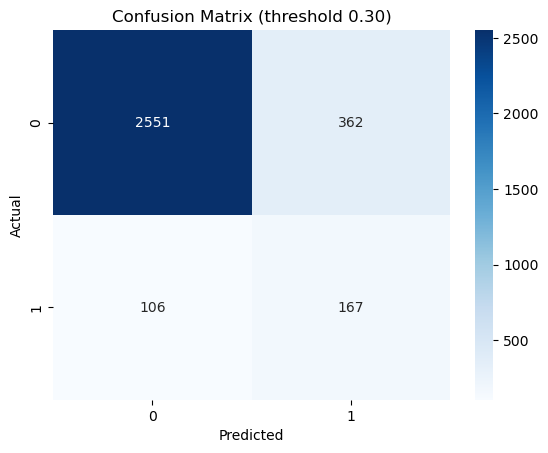

In [25]:
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
)
import seaborn as sns
import matplotlib.pyplot as plt

# Generate probability predictions
y_pred_prob = model.predict(X_test_scaled).ravel()

# Apply lower threshold (0.3) to increase sensitivity
# In clinical context, higher sensitivity is often preferred to catch more deterioration cases
threshold = 0.3
y_pred = (y_pred_prob > threshold).astype(int)

# Generate complete performance report
print(f"==> Threshold used: {threshold:.2f}\n")
print(classification_report(y_test, y_pred))

# Calculate ROC AUC and Precision-Recall AUC
print("ROC  AUC :", roc_auc_score(y_test, y_pred_prob))
print("PR   AUC :", average_precision_score(y_test, y_pred_prob))

# Generate confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (threshold {threshold:.2f})")
plt.show()

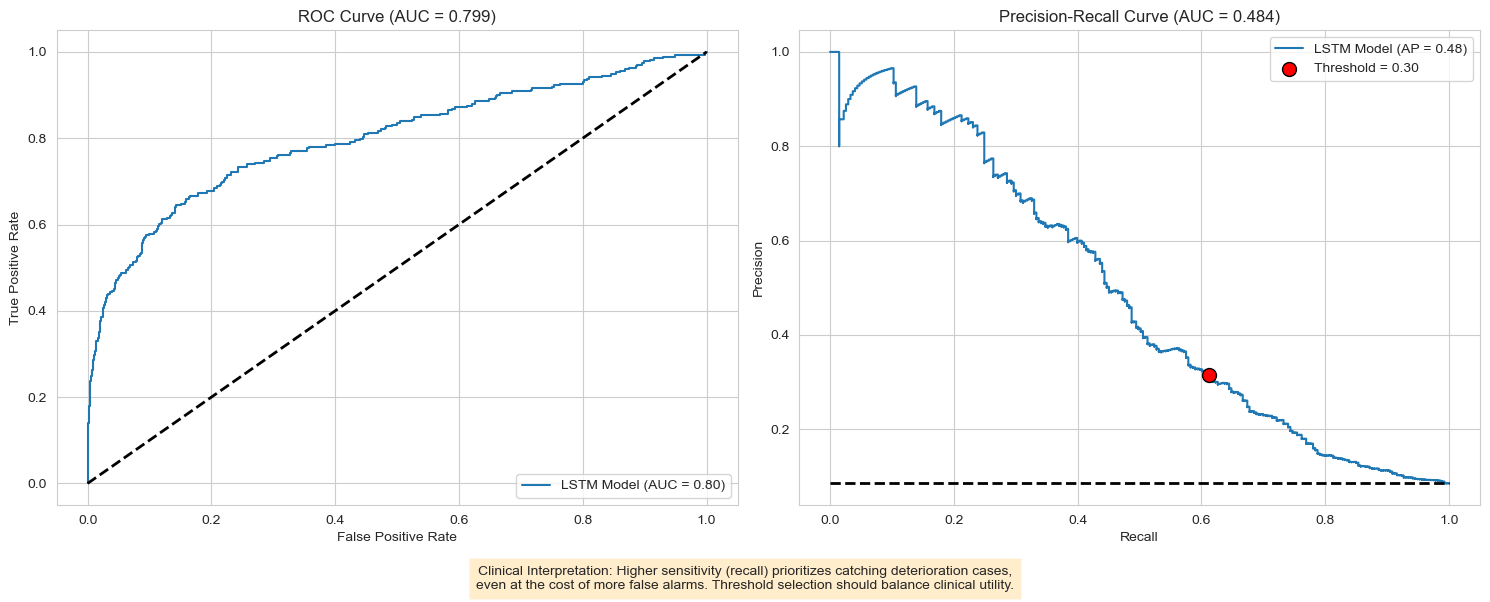

In [26]:
# Generate ROC curve and Precision-Recall curve
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import numpy as np
import seaborn as sns
# Set seaborn style for consistent visuals
sns.set_style('whitegrid')

# Create a figure with two subplots for ROC and PR curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, 
                estimator_name="LSTM Model").plot(ax=ax1)
ax1.plot([0, 1], [0, 1], 'k--', lw=2)  # Add diagonal line
ax1.set_title('ROC Curve (AUC = {:.3f})'.format(roc_auc))

# Plot Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)  # AUC for PR curve
PrecisionRecallDisplay(precision=precision, recall=recall, 
                      average_precision=pr_auc, 
                      estimator_name="LSTM Model").plot(ax=ax2)

# Add threshold indicator at the chosen threshold (0.3)
if len(thresholds_pr) > 0:
    threshold_idx = np.argmin(np.abs(thresholds_pr - threshold))
    if threshold_idx < len(precision) - 1:
        ax2.scatter(recall[threshold_idx], precision[threshold_idx], 
                   color='red', s=100, label=f'Threshold = {threshold:.2f}', 
                   zorder=5, edgecolors='black')
        ax2.legend()

ax2.set_title('Precision-Recall Curve (AUC = {:.3f})'.format(pr_auc))

# Add no-skill line for PR curve (prevalence of positive class)
no_skill = np.sum(y_test) / len(y_test)
ax2.plot([0, 1], [no_skill, no_skill], 'k--', lw=2, label='No Skill')

# Add clinical interpretation annotation
fig.text(0.5, 0.01, 
         "Clinical Interpretation: Higher sensitivity (recall) prioritizes catching deterioration cases,\n"
         "even at the cost of more false alarms. Threshold selection should balance clinical utility.", 
         ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for annotation
plt.show()

## Alternative Approach: XGBoost Model

While LSTM models capture temporal dynamics, gradient boosting models like XGBoost can provide strong performance with simpler implementation. This section implements an XGBoost model using summary statistics of the time series data.

In [27]:
import numpy as np
import pandas as pd

# Summarize time series for XGBoost by extracting key statistics
# This transforms 3D temporal data (n_stays, time_steps, features) into 2D features
# (n_stays, n_features * 5) with summary statistics for each variable

def summarise_ts(X, feature_names):
    """Extract summary statistics from time series data.
    
    Parameters:
    X -- 3D array of shape (n_stays, time_steps, n_features)
    feature_names -- List of feature names
    
    Returns:
    DataFrame with summary statistics for each feature
    """
    # Extract different summary statistics
    last  = X[:, -1, :]  # Last observed value (most recent)
    mean  = X.mean(axis=1)  # Mean across time
    std   = X.std(axis=1)   # Standard deviation
    vmin  = X.min(axis=1)   # Minimum value
    vmax  = X.max(axis=1)   # Maximum value

    # Combine all statistics
    parts = [last, mean, std, vmin, vmax]
    suffix = ["_last", "_mean", "_std", "_min", "_max"]

    # Flatten into a 2D array
    flat = np.concatenate(parts, axis=1)
    
    # Create column names
    colnames = [f"{feat}{suf}"
                for suf in suffix
                for feat in feature_names]
                
    return pd.DataFrame(flat, columns=colnames)

# Apply the function to transform the data
X_flat = summarise_ts(X, feature_cols)

In [28]:
X_flat['PULSIOX_min'].describe()

count    15927.00000
mean        76.85228
std         36.65591
min          0.00000
25%         91.00000
50%         94.00000
75%         96.00000
max         99.00000
Name: PULSIOX_min, dtype: float64

In [29]:
# Split data into training, validation and test sets
from sklearn.model_selection import train_test_split

# First split: 70% training, 30% temporary
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X_flat, y, test_size=0.30, stratify=y, random_state=42)

# Second split: divide temporary set into validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=42)

In [30]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

# Calculate class imbalance ratio for scale_pos_weight parameter
# This helps XGBoost handle imbalanced classes
ratio = (y_train == 0).sum() / (y_train == 1).sum()

# Initialize XGBoost classifier with optimized hyperparameters
xgb = XGBClassifier(
    n_estimators=800,       # Number of gradient boosted trees
    learning_rate=0.03,     # Lower learning rate for better generalization
    max_depth=4,            # Maximum tree depth to prevent overfitting
    subsample=0.8,          # Row subsampling to reduce overfitting
    colsample_bytree=0.8,   # Column subsampling to reduce overfitting
    reg_lambda=2.0,         # L2 regularization to prevent overfitting
    objective='binary:logistic',  # Binary classification with logistic function
    scale_pos_weight=ratio,       # Account for class imbalance
    eval_metric='aucpr',          # Area under precision-recall curve
    n_jobs=-1,                    # Use all available CPU cores
    random_state=42
)

# Train the model with validation monitoring
xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],  # Validation set for monitoring
    verbose=True
)

[0]	validation_0-aucpr:0.35673
[1]	validation_0-aucpr:0.36976
[2]	validation_0-aucpr:0.42645
[3]	validation_0-aucpr:0.45724
[4]	validation_0-aucpr:0.46747
[5]	validation_0-aucpr:0.48439
[6]	validation_0-aucpr:0.48917
[7]	validation_0-aucpr:0.48347
[8]	validation_0-aucpr:0.48524
[9]	validation_0-aucpr:0.48572
[10]	validation_0-aucpr:0.49317
[11]	validation_0-aucpr:0.50079
[12]	validation_0-aucpr:0.50485
[13]	validation_0-aucpr:0.50776
[14]	validation_0-aucpr:0.51849
[15]	validation_0-aucpr:0.51765
[16]	validation_0-aucpr:0.52447
[17]	validation_0-aucpr:0.52794
[18]	validation_0-aucpr:0.53397
[19]	validation_0-aucpr:0.53724
[20]	validation_0-aucpr:0.53941
[21]	validation_0-aucpr:0.54174
[22]	validation_0-aucpr:0.54526
[23]	validation_0-aucpr:0.54724
[24]	validation_0-aucpr:0.55041
[25]	validation_0-aucpr:0.54702
[26]	validation_0-aucpr:0.54629
[27]	validation_0-aucpr:0.55086
[28]	validation_0-aucpr:0.55004
[29]	validation_0-aucpr:0.55361
[30]	validation_0-aucpr:0.55720
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [31]:
# Evaluate XGBoost model on test set
# Generate probability predictions
y_prob = xgb.predict_proba(X_test)[:, 1]

# Find optimal threshold to achieve minimum 60% precision
# This threshold selection is clinically motivated to minimize false alarms
from sklearn.metrics import precision_recall_curve
prec, rec, thresh = precision_recall_curve(y_val, xgb.predict_proba(X_val)[:,1])
thr60 = thresh[np.where(prec[:-1] >= 0.6)[0][0]]  # First threshold with ≥60% precision

print(f"Threshold selected: {thr60:.2f}")

# Generate binary predictions using selected threshold
y_pred = (y_prob >= thr60).astype(int)

# Print performance metrics
print(classification_report(y_test, y_pred))
print("ROC  AUC :", roc_auc_score(y_test, y_prob))
print("PR   AUC :", average_precision_score(y_test, y_prob))

Threshold selected: 0.51
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2185
           1       0.57      0.62      0.59       205

    accuracy                           0.93      2390
   macro avg       0.77      0.79      0.78      2390
weighted avg       0.93      0.93      0.93      2390

ROC  AUC : 0.8766780152927387
PR   AUC : 0.6309824087232075


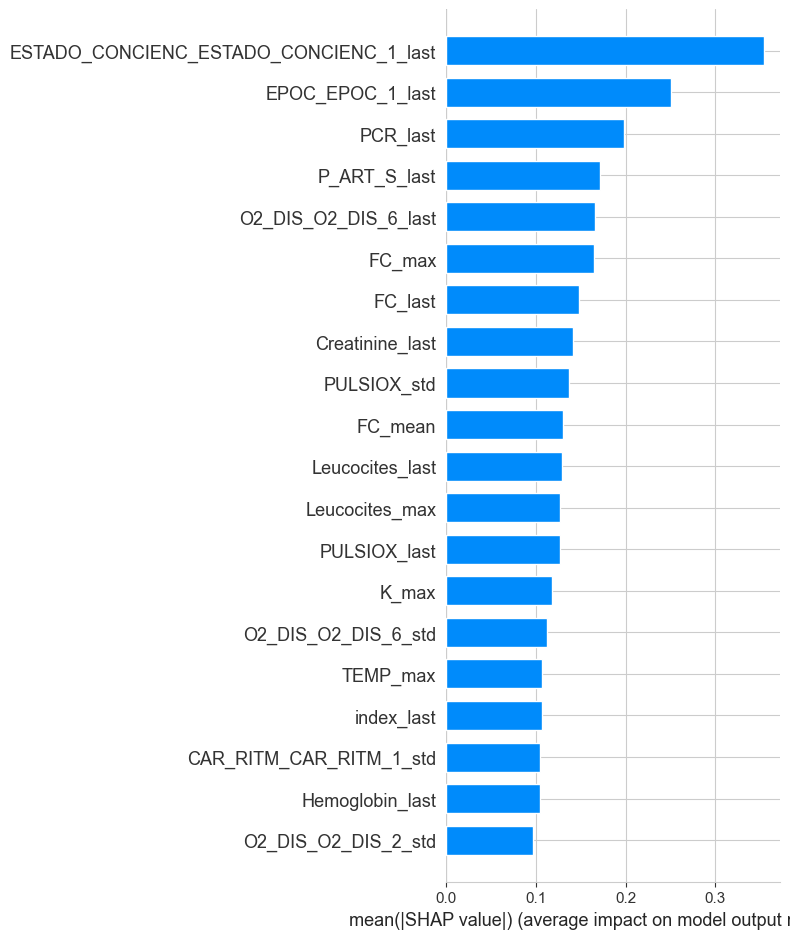

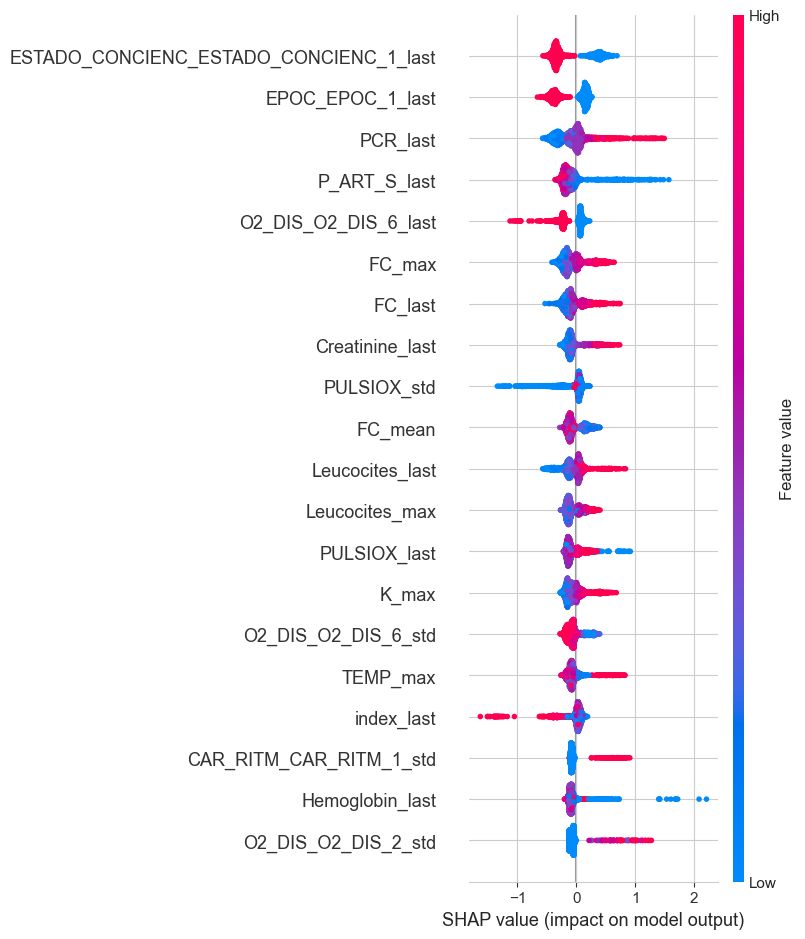

In [32]:
import shap

# Create a SHAP TreeExplainer for the trained XGBoost model
explainer = shap.TreeExplainer(xgb)

# Compute SHAP values for the test set
# X_test is the summary features DataFrame for XGBoost obtained earlier
shap_values = explainer.shap_values(X_test)

# Plot the global feature importance as a bar plot
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X_test.columns)

# Plot the detailed summary (beeswarm plot) to observe the effect of each feature
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)